In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
!pwd

/home/astanziola/repos/jwave/docs/benchmarks


In [40]:
# Load matlab results
from scipy.io import loadmat
from jax import numpy as jnp

matfile = loadmat('./kwave/homogeneous_ref.mat')
results = matfile['results']

In [41]:
N = tuple(results[0,0][0][0].tolist())
dx = tuple(results[0,0][1][0].tolist())
dt = float(results[0,0][2][0,0])
p0 = jnp.asarray(results[0,0][3], dtype=jnp.float32)
sensor_data = jnp.asarray(results[0,0][4], dtype=jnp.float32)
t_end = sensor_data.shape[-1]*dt

In [42]:
print(N)
print(dx)
print(dt)
print(p0.shape)
print(sensor_data.shape)
print(t_end)

(128, 128)
(0.0001, 0.0001)
2e-08
(128, 128)
(128, 128, 604)
1.208e-05


In [43]:
sensor_data.shape

(128, 128, 604)

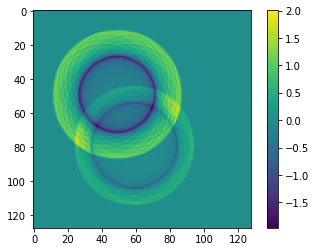

In [141]:
from matplotlib import pyplot as plt

plt.imshow(sensor_data[:,:,100])
plt.colorbar()

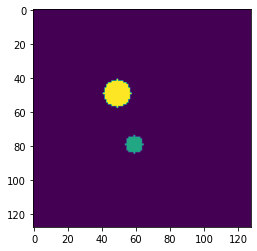

In [142]:
plt.imshow(p0)

In [143]:
# Setup wave simulation
from jwave.geometry import Domain, Medium, TimeAxis, Sources
from jwave.acoustics import ongrid_wave_propagation
from jax import jit

In [145]:
output_taxis = TimeAxis(dt=dt, t_end=t_end)
domain = Domain(N, dx)
sound_speed = jnp.ones(N)*1500

medium = Medium(
    domain=domain,
    sound_speed = sound_speed,
    density = jnp.ones(N),
    attenuation = 0,
    pml_size = 10.*dx[0]
)

In [146]:
params, solver = ongrid_wave_propagation(
    medium=medium,
    time_array=output_taxis,
)
solver = jit(solver)

In [147]:
params["initial_fields"]["rho"] = params["initial_fields"]["rho"].at[:,:,:].set(jnp.expand_dims(p0, -1)/2.)

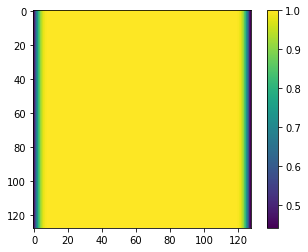

In [148]:
plt.imshow(params["integrator"]["pml_grid"][...,1])
plt.colorbar()

In [149]:
f = solver(params)

In [153]:
f[0].shape
p_pred = f[1][100][...,0] + f[1][100][...,1]

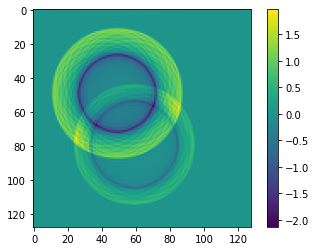

In [154]:
plt.imshow(p_pred)
plt.colorbar()

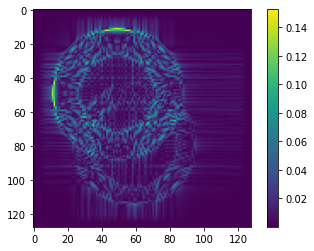

In [159]:
plt.imshow(jnp.abs(p_pred - sensor_data[:,:,102]*.5 - sensor_data[:,:,101]*.5))
plt.colorbar()